### <p style="text-align: center;">Community Segmentation</p>
# <p style="text-align: center;">Credit Card Clustering</p>
#### <p style="text-align: center;">Jeffrey D Nelson and David N Campbell</p>

The purpose of this notebook is to use K-Means clustering to segment customers based on credit card usage. This segmentation will be used to determine the marketing strategy for each segment.

## Data Exploration

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set seaborn defaults
sns.set()

df = pd.read_csv(r'data/CC_GENERAL.csv')
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [2]:
df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


## Data Preprocessing

Before we can train any models, we must preprocess the data. First, we handle non-numeric features.

In this case, there is only one non-numeric feature, `CUST_ID`. This was found using `df.select_dtypes(exclude=np.number).columns`. This feature is irrelevant, so we just drop it.

In [3]:
df = df.drop(columns=['CUST_ID'])

Next, we handle features with missing values. The simplest approach is to replace missing values with the median for the data set.

In [4]:
df.isnull().sum().sort_values(ascending=False).head()

MINIMUM_PAYMENTS          313
CREDIT_LIMIT                1
BALANCE                     0
CASH_ADVANCE_FREQUENCY      0
PRC_FULL_PAYMENT            0
dtype: int64

In [5]:
# Handle missing values in MINIMUM_PAYMENTS
min_payments_missing = df['MINIMUM_PAYMENTS'].isnull() == True
min_payments_median = df['MINIMUM_PAYMENTS'].median()

df.loc[min_payments_missing, 'MINIMUM_PAYMENTS'] = min_payments_median

# Handle missing values in CREDIT_LIMIT
credit_limit_missing = df['CREDIT_LIMIT'].isnull() == True
credit_limit_median = df['CREDIT_LIMIT'].median()

df.loc[credit_limit_missing, 'CREDIT_LIMIT'] = credit_limit_median

In [6]:
df.isnull().sum().sort_values(ascending=False).head()

BALANCE                   0
CASH_ADVANCE_FREQUENCY    0
PRC_FULL_PAYMENT          0
MINIMUM_PAYMENTS          0
PAYMENTS                  0
dtype: int64

### Scaling

After a few iterations, we realized that our clustering was performing poorly due to outliers in the dataset which could not be resolved with StandardScaler alone. Therefore, we decided to log transform features that were highly skewed.

Text(0.5, 1.0, 'Skewness of BALANCE')

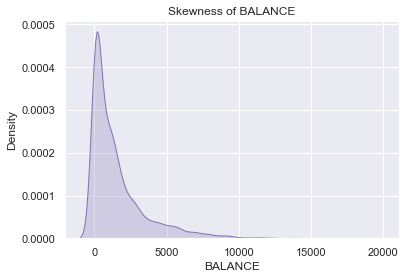

In [7]:
plt.clf()
ax = plt.gca()

g = sns.kdeplot(df['BALANCE'], color='m', shade=True, ax=ax)
g.set_title('Skewness of BALANCE')

Text(0.5, 1.0, 'Skewness of CASH_ADVANCE')

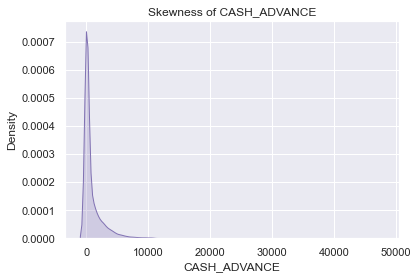

In [8]:
plt.clf()
ax = plt.gca()

g = sns.kdeplot(df['CASH_ADVANCE'], color='m', shade=True, ax=ax)
g.set_title('Skewness of CASH_ADVANCE')

In [9]:
from scipy.stats import skew

log_scale = []
standard_scale = []

for feature in df.columns:
    feature_skew = skew(df[feature])
    if feature_skew > np.abs(2):
        log_scale.append(feature)
    else:
        standard_scale.append(feature)
    print("Skew for %s: %f" % (feature, feature_skew))

Skew for BALANCE: 2.392985
Skew for BALANCE_FREQUENCY: -2.022926
Skew for PURCHASES: 8.142904
Skew for ONEOFF_PURCHASES: 10.043399
Skew for INSTALLMENTS_PURCHASES: 7.297897
Skew for CASH_ADVANCE: 5.165743
Skew for PURCHASES_FREQUENCY: 0.060154
Skew for ONEOFF_PURCHASES_FREQUENCY: 1.535355
Skew for PURCHASES_INSTALLMENTS_FREQUENCY: 0.509116
Skew for CASH_ADVANCE_FREQUENCY: 1.828380
Skew for CASH_ADVANCE_TRX: 5.720339
Skew for PURCHASES_TRX: 4.629879
Skew for CREDIT_LIMIT: 1.522381
Skew for PAYMENTS: 5.906630
Skew for MINIMUM_PAYMENTS: 13.850125
Skew for PRC_FULL_PAYMENT: 1.942494
Skew for TENURE: -2.942524


As you can see, some features are heavily right-skewed (high positive value). For those features with a right-skew greater than 3, we will log transform them. The other features will be scaled normally.

In [10]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler

scaler = make_column_transformer(
    (StandardScaler(), standard_scale),
    (FunctionTransformer(np.log1p), log_scale)
)
X = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)

In [11]:
X.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-0.249434,-0.806490,-0.678661,-0.707313,-0.675349,-0.960378,-0.525551,0.36068,3.735304,4.568506,0.000000,4.568506,0.000000,0.000000,1.098612,5.312231,4.945277
1,0.134325,-1.221758,-0.678661,-0.916995,0.573963,0.688678,0.234227,0.36068,8.071989,0.000000,0.000000,0.000000,8.770896,1.609438,0.000000,8.319725,6.978531
2,0.518084,1.269843,2.673451,-0.916995,-0.675349,0.826100,-0.525551,0.36068,7.822504,6.651791,6.651791,0.000000,0.000000,0.000000,2.564949,6.434654,6.442994
3,-1.016953,-1.014125,-0.399319,-0.916995,-0.258913,0.826100,-0.525551,0.36068,7.419183,7.313220,7.313220,0.000000,5.331694,0.693147,0.693147,0.000000,5.747301
4,0.518084,-1.014125,-0.399319,-0.916995,-0.675349,-0.905410,-0.525551,0.36068,6.707735,2.833213,2.833213,0.000000,0.000000,0.000000,0.693147,6.521114,5.504483


### Feature Correlations

The correlation between features is an important relationship to explore, and a great way to visualize these correlations is using a heat map, which seaborn makes simple.

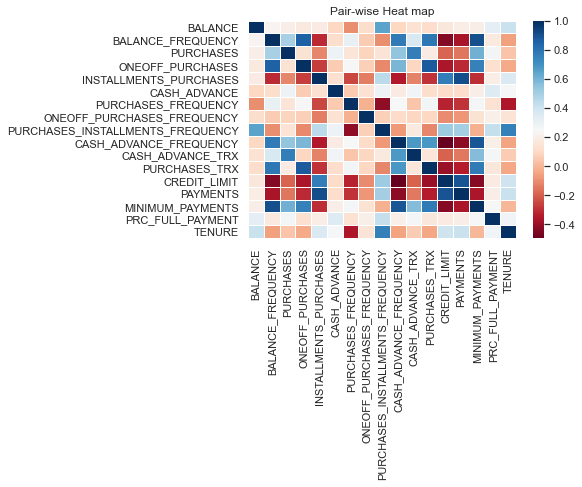

In [12]:
import seaborn as sns

g = sns.heatmap(X.corr(), annot=False, linewidths=0.1, vmax=1.0, linecolor='white', cmap=plt.cm.RdBu)
g.set_title("Pair-wise Heat map")
plt.show()

The more blue a block is, the more positively correlated two features are. The more red a block is, the more negatively correlated two features are.

From this graph, there are a few strong positive relationships, like CASH_ADVANCE_FREQUENCY and CASH_ADVANCE_TRX. This correlation makes intuitive sense, and so these features can likely be decomposed into a single feature. Other notable correlations are:
TODO

## PCA

Since there are so many features, we use PCA to decompose to the subset that captures the majority of the variance in the dataset.

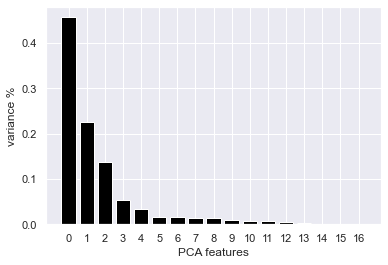

In [13]:
from sklearn.decomposition import PCA

num_features = len(df.columns)

pca = PCA(n_components=num_features)
principal_components = pca.fit_transform(X)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()

To explain > 80% of the variance, it will take ~3 features. Show how much each original feature contributes to PCA vectors.

In [17]:
pca = PCA(n_components=3)
X_pca = pd.DataFrame(pca.fit_transform(X), index=df.index, columns=['PC-1', 'PC-2', 'PC-3'])
X_pca.head()

,PC-1,PC-2,PC-3
0,0.773798,-5.622241,0.522528
1,-9.049282,1.473693,1.063849
2,2.865288,1.691673,-5.194934
3,-0.645728,2.667291,-4.864997
4,-1.472411,-2.718009,-3.733230


In [18]:
pc_df = pd.DataFrame(pca.components_.T, columns=['PC-1', 'PC-2', 'PC-3'], index=df.columns)
pc_df

,PC-1,PC-2,PC-3
BALANCE,0.004778,0.119412,0.078498
BALANCE_FREQUENCY,0.153430,0.030969,0.124680
PURCHASES,0.100153,0.136310,-0.108376
ONEOFF_PURCHASES,0.126128,-0.011283,0.215539
INSTALLMENTS_PURCHASES,-0.108399,0.136568,0.076272
CASH_ADVANCE,0.023477,0.108885,0.015855
PURCHASES_FREQUENCY,0.065632,-0.061615,0.017301
ONEOFF_PURCHASES_FREQUENCY,0.025487,0.018646,0.007902
PURCHASES_INSTALLMENTS_FREQUENCY,-0.099491,0.402800,0.124907
CASH_ADVANCE_FREQUENCY,0.511592,0.216480,0.040010


## K-Means

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []
clusters = [ i for i in range(2, 12) ]

for i in clusters:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_pca)
    score = silhouette_score(X_pca, kmeans.predict(X_pca))
    print("Silhouette score for {num} clusters: {score}".format(num=i, score=score))
    silhouette_scores.append(score)

Silhouette score for 2 clusters: 0.4195586158338325
Silhouette score for 3 clusters: 0.4084723470946527
Silhouette score for 4 clusters: 0.4703700067979213
Silhouette score for 5 clusters: 0.5110440056190817
Silhouette score for 6 clusters: 0.5324279224544521
Silhouette score for 7 clusters: 0.5525245142915558
Silhouette score for 8 clusters: 0.5046933071371543
Silhouette score for 9 clusters: 0.46269819329898
Silhouette score for 10 clusters: 0.4344929095703674
Silhouette score for 11 clusters: 0.4268342704556666


In [21]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(X_pca)

KMeans(n_clusters=7)

In [22]:
kmeans.cluster_centers_

array([[ 6.46223298,  1.01235363, -0.32259097],
       [-8.04435207, -0.59059466,  0.04133414],
       [ 2.59605917, -4.76236953,  2.02818179],
       [ 1.93768387, -0.76265028, -5.23930081],
       [ 1.96619001,  5.90174637,  2.32784455],
       [-1.58836393,  1.40508111,  5.03250463],
       [-2.48522206,  4.40413212, -2.32864632]])

In [26]:
# ColumnTransformer has no inverse transform...
inverse_array = pd.DataFrame(pca.inverse_transform(kmeans.cluster_centers_), columns=df.columns)
for feature in log_scale:
    inverse_array[feature] = np.exp

array([[ 1.26443621e-01,  9.82631164e-01,  8.20170014e-01,
         7.34118078e-01, -5.86851050e-01,  2.56827710e-01,
         3.56169231e-01,  1.81033232e-01,  5.88618286e+00,
         8.41192147e+00,  6.33032650e+00,  5.96159904e+00,
         4.82407035e-01,  1.22609549e-01,  3.44456261e+00,
         7.04568806e+00,  5.75758269e+00],
       [-1.05718892e-01, -1.24738108e+00, -8.90653257e-01,
        -9.99049014e-01,  7.94498076e-01, -2.52506767e-01,
        -4.90858689e-01, -2.15715739e-01,  6.72925216e+00,
         6.58022245e-01, -1.23293557e-01, -1.50568241e-01,
         7.10347374e+00,  1.75372864e+00, -7.90354737e-03,
         6.21368111e+00,  6.19403578e+00],
       [-3.97068961e-01,  5.03699480e-01, -6.08960200e-01,
         8.18324277e-01, -7.77102276e-01, -4.25447305e-01,
         4.98904790e-01, -6.60596477e-03,  4.23840604e+00,
         5.27796141e+00,  4.38542430e-01,  5.93896562e+00,
         3.11330582e-02, -6.43576610e-02,  2.24141333e+00,
         5.85137498e+00,  5.1

In [ ]:
inverse_center_df = pd.DataFrame(inverse_array, columns=df.columns)
inverse_center_df

## References

Remember to specify the references.